In [1]:
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [10]:
def load_photos(directory):
    images = []
    labelsR = []
    labelsS = []
    for name in listdir(directory):
        filename = directory + '/' + name
        # convert image to gray
        img = Image.open(filename).convert('L')
        img.save(filename)
        # load an image from file
        image = load_img(filename, target_size=(160, 128), grayscale=True)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # get image id + labels
        labelsR.append(round(float(name.split('_')[0].split('-')[0]) / float(name.split('_')[0].split('-')[1]), 1))
        labelsS.append(round(((float(name.split('_')[0].split('-')[0]) + float(name.split('_')[0].split('-')[1])) / 2), 1))
        images.append(image)
    return images, labelsR, labelsS

In [11]:
# load images from both train and test groups
directory = '../data/Patate_Pics/Training'
images, labelsR, labelsS = load_photos(directory)
nb_images = len(images)
print('Loaded Images and labels for training: %d' % nb_images)
directory = '../data/Patate_Pics/Validation'
images_val, labelsR_val, labelsS_val = load_photos(directory)
nb_images_val = len(images_val)
print('Loaded Images and labels for validation: %d' % nb_images_val)

Loaded Images and labels for training: 643
Loaded Images and labels for validation: 105


In [12]:
#normalise datas
images = np.array(images)
images /= 255
images_val = np.array(images_val)
images_val /= 255

In [13]:
#convert to np.array
labelsR = np.array(labelsR)
labelsS = np.array(labelsS)
labelsR_val = np.array(labelsR_val)
labelsS_val = np.array(labelsS_val)

In [14]:
#convert datas to dummyvalues
labelsRd = pd.get_dummies(labelsR)
labelsSd = pd.get_dummies(labelsS)

In [15]:
labelsRd.shape, labelsSd.shape

((643, 17), (643, 8))

In [16]:
#append empty columns
#labelsRd.insert(0, column='0.1', value=0, allow_duplicates=False)
#labelsSd.insert(0, column='0.1', value=0, allow_duplicates=False)
labelsRd, labelsSd

(     0.4  0.5  0.6  0.7  0.8  0.9  1.0  1.1  1.2  1.3  1.4  1.5  1.6  1.7  \
 0      1    0    0    0    0    0    0    0    0    0    0    0    0    0   
 1      0    0    1    0    0    0    0    0    0    0    0    0    0    0   
 2      0    0    1    0    0    0    0    0    0    0    0    0    0    0   
 3      0    0    0    0    0    0    0    1    0    0    0    0    0    0   
 4      0    1    0    0    0    0    0    0    0    0    0    0    0    0   
 5      0    0    1    0    0    0    0    0    0    0    0    0    0    0   
 6      0    0    0    0    0    0    0    0    0    0    0    0    0    0   
 7      0    0    0    0    0    0    0    0    1    0    0    0    0    0   
 8      0    0    0    0    0    0    0    1    0    0    0    0    0    0   
 9      0    0    0    0    0    0    1    0    0    0    0    0    0    0   
 10     0    0    0    0    0    1    0    0    0    0    0    0    0    0   
 11     0    0    0    0    0    0    0    0    1    0    0    0

In [17]:
#convert to np.array again
labelsRd = np.array(labelsRd)
labelsSd = np.array(labelsSd)

In [19]:
#check if OK
labelsR[1], labelsRd[1]

(0.59999999999999998,
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8))

In [20]:
from keras.models import Model
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers

In [21]:
K.clear_session()

img_in = Input(shape=(160, 128, 1), name='img_in')

x = img_in

x = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

flat = Flatten()(x)

out1 = Dense(17, activation='softmax')(flat)
out2 = Dense(8, activation='softmax')(flat)

model = Model(inputs=[img_in], outputs=[out1, out2])
model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer='adadelta', metrics=['accuracy'])

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
img_in (InputLayer)              (None, 160, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 160, 128, 8)   80          img_in[0][0]                     
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 80, 64, 8)     0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 80, 64, 16)    1168        max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [24]:
h = model.fit(images, [labelsRd, labelsSd], batch_size=1, epochs=50, verbose=1)

Epoch 1/50
643/643 [==============================] - 8s - loss: 3.5913 - dense_1_loss: 2.0004 - dense_2_loss: 1.5910 - dense_1_acc: 0.2691 - dense_2_acc: 0.3219     
Epoch 2/50
643/643 [==============================] - 8s - loss: 3.4453 - dense_1_loss: 1.9045 - dense_2_loss: 1.5408 - dense_1_acc: 0.3406 - dense_2_acc: 0.3406     
Epoch 3/50
643/643 [==============================] - 9s - loss: 3.2017 - dense_1_loss: 1.6922 - dense_2_loss: 1.5094 - dense_1_acc: 0.4448 - dense_2_acc: 0.3810     
Epoch 4/50
643/643 [==============================] - 9s - loss: 3.0068 - dense_1_loss: 1.5286 - dense_2_loss: 1.4782 - dense_1_acc: 0.4541 - dense_2_acc: 0.4199     
Epoch 5/50
643/643 [==============================] - 8s - loss: 2.9200 - dense_1_loss: 1.4610 - dense_2_loss: 1.4591 - dense_1_acc: 0.4868 - dense_2_acc: 0.4323     
Epoch 6/50
643/643 [==============================] - 8s - loss: 2.8643 - dense_1_loss: 1.4177 - dense_2_loss: 1.4465 - dense_1_acc: 0.4946 - dense_2_acc: 0.4339    

643/643 [==============================] - 10s - loss: 0.0179 - dense_1_loss: 3.0888e-05 - dense_2_loss: 0.0178 - dense_1_acc: 1.0000 - dense_2_acc: 0.9969    
Epoch 50/50
643/643 [==============================] - 10s - loss: 0.0012 - dense_1_loss: 5.8433e-05 - dense_2_loss: 0.0011 - dense_1_acc: 1.0000 - dense_2_acc: 1.0000    


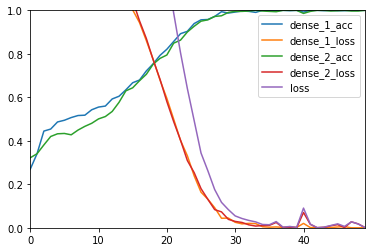

In [26]:
#print History graph
historydf = pd.DataFrame(h.history, index=h.epoch)
historydf.plot(ylim=(0,1))

In [29]:
# Get predictions
all_preds = model.predict(images_val)

# Check predictions
idxR = np.argmax(all_preds[0], axis=1)
idxS = np.argmax(all_preds[1], axis=1)

idxR, idxS, labelsR_val, labelsS_val

(array([ 7,  5,  3,  5,  3,  6,  2,  7,  3,  7,  4,  7,  8,  5,  8,  7,  5,
         6,  5,  5,  5, 10, 10,  7,  6,  7, 10,  6,  7,  7,  8,  7,  6,  6,
         5,  6,  6,  5,  3,  6,  5,  4,  5,  6,  5,  8,  6,  6,  6,  5,  6,
         6,  6,  6,  4,  5,  5,  5,  6,  6,  7,  7,  8,  4,  7,  7,  6,  5,
         7,  5,  8,  7,  7,  8,  6,  7,  7,  7,  7,  8,  7,  7,  7,  7,  6,
         5,  6,  6,  7,  7,  6,  6,  5,  5,  7,  7,  6,  8,  5,  6, 10,  7,
         7,  7,  5], dtype=int64),
 array([5, 4, 5, 6, 5, 5, 6, 5, 4, 3, 4, 5, 4, 5, 5, 3, 4, 6, 3, 5, 4, 1, 3,
        5, 5, 3, 3, 4, 3, 3, 3, 4, 5, 5, 5, 4, 6, 5, 4, 6, 4, 4, 4, 6, 5, 4,
        4, 4, 6, 5, 5, 5, 5, 4, 5, 4, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 5, 4, 5,
        2, 3, 4, 4, 5, 6, 3, 5, 4, 3, 3, 4, 4, 3, 4, 6, 5, 3, 6, 5, 3, 5, 5,
        6, 5, 3, 4, 5, 7, 4, 4, 3, 3, 5, 4, 3], dtype=int64),
 array([ 0.8,  0.6,  0.5,  0.7,  0.7,  0.8,  0.8,  0.7,  0.7,  1. ,  0.7,
         1.4,  1.3,  1.1,  1. ,  1. ,  0.9,  0.9,  0.9,  0.9,  0.

In [41]:
model.save('test_model.h5')